In [23]:
p=0.8


In [24]:
import numpy as np
from qiskit.circuit import QuantumCircuit

In [25]:
class BernoulliA(QuantumCircuit):
    def __init__(self,probs):
        super().__init__(1)
        theta_p=2*np.arcsin(np.sqrt(probs))

        self.ry(theta_p,0)
class BernoulliQ(QuantumCircuit):
    def __init__(self,probs):
        super().__init__(1)
        self._theta_p=2*np.arcsin(np.sqrt(probs))
        self.ry(2*self._theta_p,0)
    def power(self,k):
        q_k=QuantumCircuit(1)
        q_k.ry(2*k*self._theta_p,0)
        return q_k

In [26]:
A=BernoulliA(p)
Q=BernoulliQ(p)



In [27]:
from qiskit_algorithms import EstimationProblem 

problem=EstimationProblem(
    state_preparation=A,
    grover_operator=Q,
    objective_qubits=[0],
)

In [28]:
from qiskit.primitives import Sampler
sampler=Sampler()



In [29]:
from qiskit_algorithms import AmplitudeEstimation

ae=AmplitudeEstimation(
    num_eval_qubits=3,
    sampler=sampler,
)

In [30]:
ae_result=ae.estimate(problem)
print(ae_result.estimation)

0.8535534


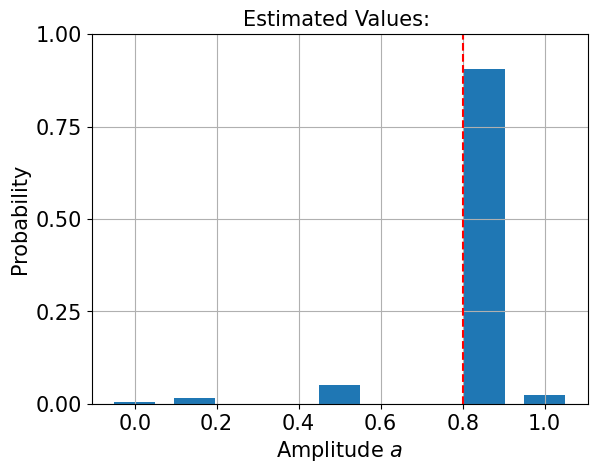

In [31]:
import matplotlib.pyplot as plt 

gridpoints=list(ae_result.samples.keys())
probs=list(ae_result.samples.values())

plt.bar(gridpoints,probs,width=0.5/len(probs))
plt.axvline(p,color="r",ls="--")

plt.xticks(size=15)
plt.yticks([0,0.25,0.5,0.75,1],size=15)

plt.title("Estimated Values: ",size=15)
plt.ylabel("Probability", size=15)
plt.xlabel(r"Amplitude $a$", size=15)
plt.ylim((0, 1))
plt.grid()
plt.show()

In [32]:
print("Interpolated MLE Estimator: ",ae_result.mle)

Interpolated MLE Estimator:  0.8000000045268789


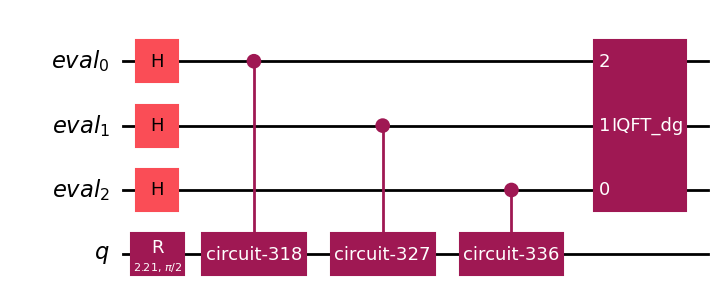

In [33]:
ae_circuit=ae.construct_circuit(problem)
ae_circuit.decompose().draw(
    "mpl",style="iqp",
)

In [48]:
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager 

from qiskit_ibm_runtime import EstimatorV2 as Estimator

from qiskit.visualization import plot_distribution
from qiskit.quantum_info import SparsePauliOp

In [53]:
service=QiskitRuntimeService()
backend=service.backend("ibm_brisbane")
print(backend.name)

obs=SparsePauliOp("Z"*127)

ibm_brisbane


In [54]:
pm=generate_preset_pass_manager(backend=backend,optimization_level=2)

opt_qc=pm.run(ae_circuit)

estimator=Estimator(mode=backend)

pub=estimator.run([(opt_qc,obs)])

print(f"Job Id: {pub.job_id()}")


Job Id: cvmp240j1gcg008xp900


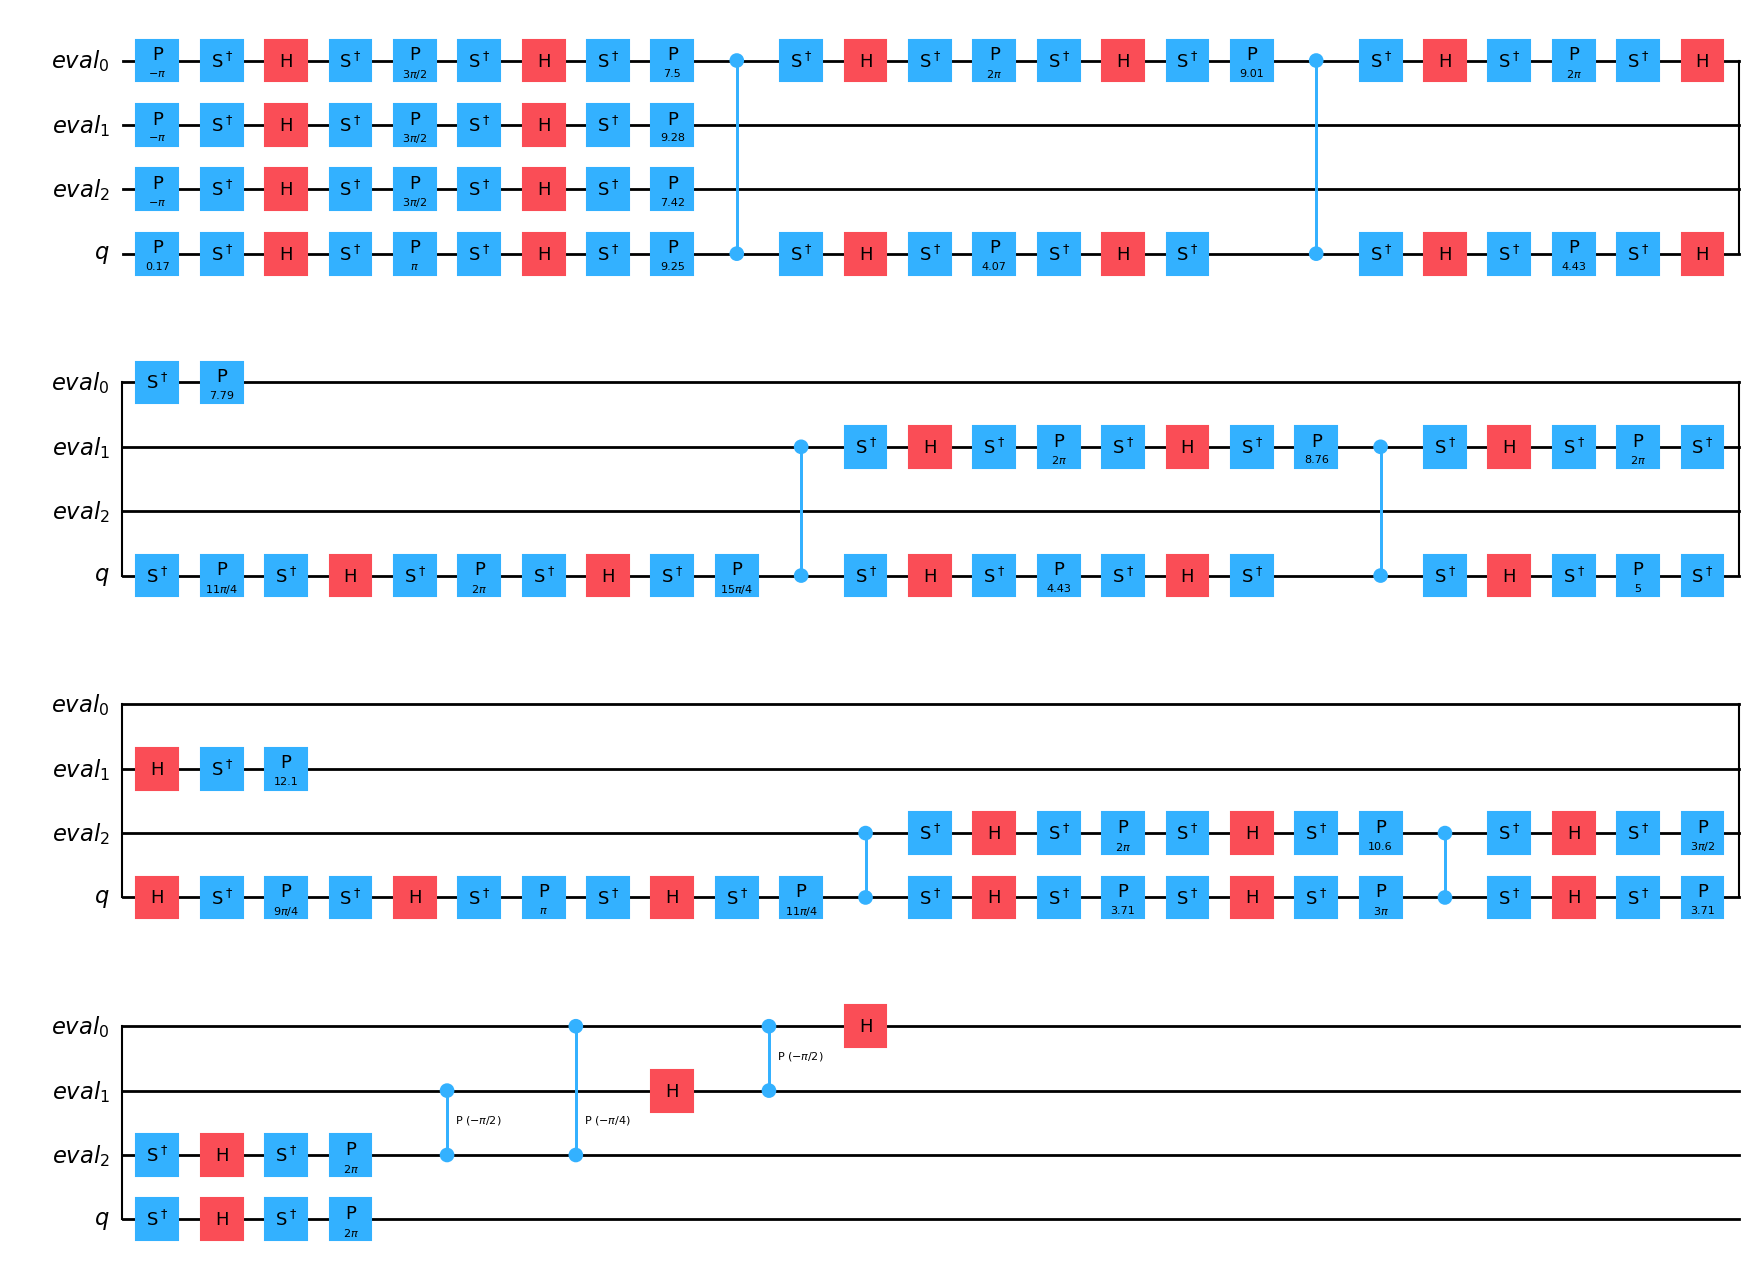

In [34]:
from qiskit import transpile 

basis=["h", "ry", "cry", "cx", "ccx", "p", "cp", "x", "s", "sdg", "y", "t", "cz"]

transpile(ae_circuit,basis_gates=basis,optimization_level=2).draw(output="mpl")

$\textbf{Iterative Amplitude Estimation}$

In [35]:
from qiskit_algorithms import IterativeAmplitudeEstimation 

iae=IterativeAmplitudeEstimation(
    epsilon_target=0.01,
    alpha=0.05,
    sampler=sampler
    )
iae_result=iae.estimate(problem)
print(f"Estimate: {iae_result.estimation}")

Estimate: 0.7999999999999999


**The circuits here only consist of Grover powers and are much cheaper!**

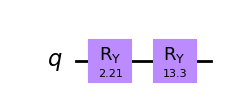

In [37]:
iae_circ=iae.construct_circuit(problem,k=3)
iae_circ.draw(output="mpl",style="clifford")

$\textbf{Maximum Likelihood Amplitude Estimation}$

In [38]:
from qiskit_algorithms import MaximumLikelihoodAmplitudeEstimation 

mlae=MaximumLikelihoodAmplitudeEstimation(
    evaluation_schedule=3,
    sampler=sampler,
)
mlae_result=mlae.estimate(problem)

print(f"MLAE Estimate: {mlae_result.estimation}")

MLAE Estimate: 0.8000208752113787


$\textbf{Faster Amplitude Estimation}$

In [40]:
from qiskit_algorithms import FasterAmplitudeEstimation 

fae=FasterAmplitudeEstimation(
    delta=0.01,
    maxiter=3,
    sampler=sampler,
)
fae_result=fae.estimate(problem)
print(f"Estimate using FAE: {fae_result.estimation}")

Estimate using FAE: 0.7935335817858019


c:\Users\Rajat\AppData\Local\Programs\Python\Python311\Lib\site-packages\qiskit_algorithms\amplitude_estimators\estimation_problem.py:214: UserWarning: Rescaling discards the Grover operator.
  warnings.warn("Rescaling discards the Grover operator.")


In [58]:

from qiskit import QuantumCircuit
from qiskit_algorithms import IterativeAmplitudeEstimation, EstimationProblem
from qiskit.circuit.library import LinearAmplitudeFunction
from qiskit_aer.primitives import Sampler
from qiskit_finance.circuit.library import LogNormalDistribution

In [70]:
num_uncertainty_qubits = 3
S=0.6
vol=0.4
r=0.05
T=40/365

mu=(r-0.5*vol**2)*T+np.log(S)
sigma = vol * np.sqrt(T)
mean = np.exp(mu + sigma**2 / 2)
variance = (np.exp(sigma**2) - 1) * np.exp(2 * mu + sigma**2)
stddev = np.sqrt(variance)

low=np.maximum(0,mean-3*stddev)
high=mean+3*stddev

uncertainty_model=LogNormalDistribution(
    num_uncertainty_qubits,
    mu=mu,
    sigma=sigma**2,
    bounds=(low,high)
)


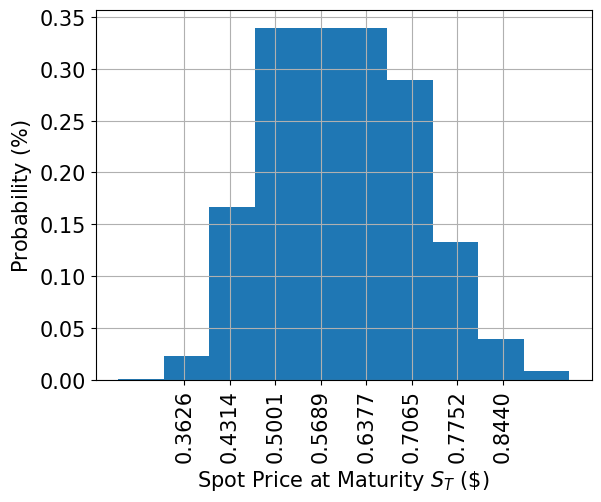

In [71]:
x = uncertainty_model.values
y = uncertainty_model.probabilities
plt.bar(x, y, width=0.2)
plt.xticks(x, size=15, rotation=90)
plt.yticks(size=15)
plt.grid()
plt.xlabel("Spot Price at Maturity $S_T$ (\$)", size=15)
plt.ylabel("Probability ($\%$)", size=15)
plt.show()

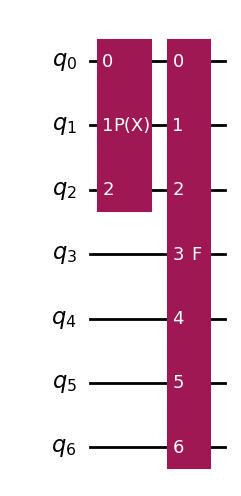

In [78]:
strike_price=0.5689

c_approx=0.25

breakpoints=[low,strike_price]

slopes = [0, 1]
offsets = [0, 0]
f_min = 0
f_max = high - strike_price
european_call_objective = LinearAmplitudeFunction(
    num_uncertainty_qubits,
    slopes,
    offsets,
    domain=(low, high),
    image=(f_min, f_max),
    breakpoints=breakpoints,
    rescaling_factor=c_approx,
)

# construct A operator for QAE for the payoff function by
# composing the uncertainty model and the objective
num_qubits = european_call_objective.num_qubits
european_call = QuantumCircuit(num_qubits)
european_call.append(uncertainty_model, range(num_uncertainty_qubits))
european_call.append(european_call_objective, range(num_qubits))

# draw the circuit
european_call.decompose().draw(output="mpl")


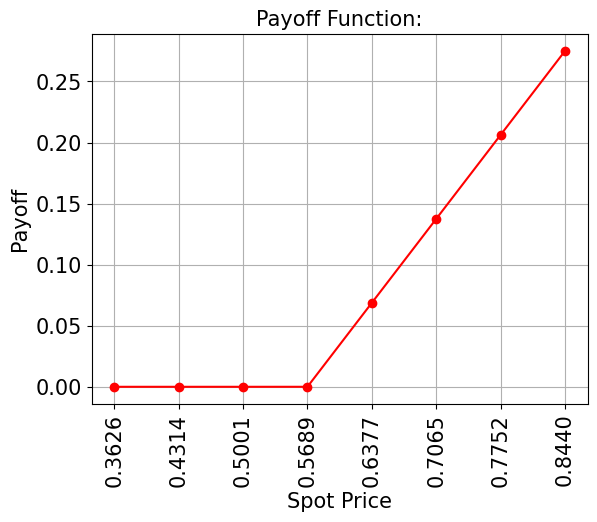

In [79]:
x=uncertainty_model.values
y=np.maximum(0,x-strike_price)

plt.plot(x,y,"ro-")
plt.grid()

plt.title("Payoff Function:",size=15)
plt.xlabel("Spot Price",size=15)
plt.ylabel("Payoff",size=15)

plt.xticks(x,size=15,rotation=90)
plt.yticks(size=15)
plt.show()

In [83]:
exact_value = np.dot(uncertainty_model.probabilities, y)
exact_delta = sum(uncertainty_model.probabilities[x >= strike_price])
print("exact expected value:\t%.4f" % exact_value)
print("exact delta value:   \t%.4f" % exact_delta)

exact expected value:	0.0486
exact delta value:   	0.8098


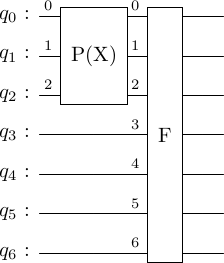

In [86]:
european_call.draw(output="latex")

In [80]:
epsilon = 0.01
alpha = 0.05

problem = EstimationProblem(
    state_preparation=european_call,
    objective_qubits=[3],
    post_processing=european_call_objective.post_processing,
)
# construct amplitude estimation
ae = IterativeAmplitudeEstimation(
    epsilon_target=epsilon, alpha=alpha, sampler=Sampler(run_options={"shots": 100, "seed": 75})
)

In [84]:
result=ae.estimate(problem)
conf_int = np.array(result.confidence_interval_processed)
print("Exact value:        \t%.4f" % exact_value)
print("Estimated value:    \t%.4f" % (result.estimation_processed))
print("Confidence interval:\t[%.4f, %.4f]" % tuple(conf_int))

Exact value:        	0.0486
Estimated value:    	0.0505
Confidence interval:	[0.0490, 0.0520]


$\text{Evaluate Delta }$

In [87]:
from qiskit_finance.applications.estimation import EuropeanCallDelta

european_call_delta = EuropeanCallDelta(
    num_state_qubits=num_uncertainty_qubits,
    strike_price=strike_price,
    bounds=(low, high),
    uncertainty_model=uncertainty_model,
)

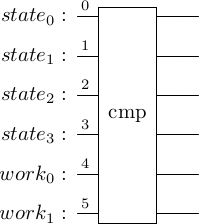

In [89]:
european_call_delta._objective.decompose().draw(output="latex")

In [90]:
european_call_delta_circ = QuantumCircuit(european_call_delta._objective.num_qubits)
european_call_delta_circ.append(uncertainty_model, range(num_uncertainty_qubits))
european_call_delta_circ.append(
    european_call_delta._objective, range(european_call_delta._objective.num_qubits)
)

european_call_delta_circ.draw()

┌───────┐┌──────┐
q_0: ┤0      ├┤0     ├
     │       ││      │
q_1: ┤1 P(X) ├┤1     ├
     │       ││      │
q_2: ┤2      ├┤2     ├
     └───────┘│  ECD │
q_3: ─────────┤3     ├
              │      │
q_4: ─────────┤4     ├
              │      │
q_5: ─────────┤5     ├
              └──────┘

In [91]:
epsilon = 0.01
alpha = 0.05

problem = european_call_delta.to_estimation_problem()

# construct amplitude estimation
ae_delta = IterativeAmplitudeEstimation(
    epsilon_target=epsilon, alpha=alpha, sampler=Sampler(run_options={"shots": 100, "seed": 75})
)

In [92]:

result_delta = ae_delta.estimate(problem)
conf_int = np.array(result_delta.confidence_interval_processed)
print("Exact delta:    \t%.4f" % exact_delta)
print("Estimated value: \t%.4f" % european_call_delta.interpret(result_delta))
print("Confidence interval: \t[%.4f, %.4f]" % tuple(conf_int))

Exact delta:    	0.8098
Estimated value: 	0.8091
Confidence interval: 	[0.8034, 0.8148]
